In [64]:
import pandas as pd
import datetime
from datetime import date
import numpy as np
import yfinance as yf
import pytrade
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:,.3f}'.format

In [65]:
def get_analysis(ratios):
    three_wk_mask = date.today()-ratios.index.date <= datetime.timedelta(days=21)
    three_m_mask = date.today()-ratios.index.date <= datetime.timedelta(days=91)
    one_yr_mask = date.today()-ratios.index.date <= datetime.timedelta(days=365)

    # Format Analysis
    analysis = pd.DataFrame(ratios.iloc[-1])
    analysis.rename({analysis.columns[0]:"latest"}, axis = 1, inplace = True) # Better way to do this?
    analysis["three_wk_high"] = pd.DataFrame(ratios[three_wk_mask].max())
    analysis["three_wk_low"] = pd.DataFrame(ratios[three_wk_mask].min())
    analysis["three_m_high"] = pd.DataFrame(ratios[three_m_mask].max())
    analysis["three_m_low"] = pd.DataFrame(ratios[three_m_mask].min())
    analysis["one_yr_high"] = pd.DataFrame(ratios[one_yr_mask].max())
    analysis["one_yr_low"] = pd.DataFrame(ratios[one_yr_mask].min())
    # Better way to do this?
    analysis["three_wk_range"] = (analysis["latest"] - analysis["three_wk_low"]) / ((analysis["three_wk_high"] - analysis["three_wk_low"]))
    analysis["three_m_range"] = (analysis["latest"] - analysis["three_m_low"]) / ((analysis["three_m_high"] - analysis["three_m_low"]))
    analysis["one_yr_range"] = (analysis["latest"] - analysis["one_yr_low"]) / ((analysis["one_yr_high"] - analysis["one_yr_low"]))
    analysis["short_term_stochastic"] = analysis["one_yr_range"] - analysis["three_wk_range"]
    analysis["long_term_stochastic"] = analysis["one_yr_range"] - analysis["three_m_range"]
    #analysis["short_term_potential"] = 1-analysis["latest"] / analysis["three_wk_high"]
    #analysis["long_term_potential"] = 1-analysis["latest"] / analysis["three_m_high"]
    st_equilibrium = (analysis["three_wk_low"] * analysis["one_yr_high"] - analysis["one_yr_low"] * analysis["three_wk_high"]) / \
        (analysis["one_yr_high"] - analysis["three_wk_high"] + analysis["three_wk_low"] - analysis["one_yr_low"])
    real_st_potential = st_equilibrium / analysis["latest"] - 1
    analysis["st_potential"] = real_st_potential
    lt_equilibrium = (analysis["three_m_low"] * analysis["one_yr_high"] - analysis["one_yr_low"] * analysis["three_m_high"]) / \
        (analysis["one_yr_high"] - analysis["three_m_high"] + analysis["three_m_low"] - analysis["one_yr_low"])
    real_lt_potential = lt_equilibrium / analysis["latest"] - 1
    analysis["lt_potential"] = real_lt_potential
    st_multiplier = abs((1 - analysis["short_term_stochastic"]) / real_st_potential).min()
    analysis["short_term_metric"] = analysis["short_term_stochastic"] + st_multiplier * real_st_potential
    lt_multiplier = abs((1 - analysis["long_term_stochastic"]) / real_lt_potential).min()
    analysis["long_term_metric"] = analysis["long_term_stochastic"] + lt_multiplier * real_lt_potential
    # Save file

    # Return output
    return analysis

In [66]:
%%time
r = pytrade.get_data(reload=True)
ratios = pytrade.calculate_ratio(r)
output = get_analysis(ratios)
output.sort_values(by="short_term_metric",ascending=False,inplace=True)
my_shortterm = output.loc[["DG","BLK","ZBRA","QRVO","AMD","LULU","MSFT"]]
my_longterm = output.loc[["AMGN","AAPL","WMT","OKE","INTC","KLAC","REGN"]]
output

[*********************100%***********************]  537 of 537 completed
Wall time: 1min 40s


,latest,three_wk_high,three_wk_low,three_m_high,three_m_low,one_yr_high,one_yr_low,three_wk_range,three_m_range,one_yr_range,short_term_stochastic,long_term_stochastic,st_potential,lt_potential,short_term_metric,long_term_metric
SGEN,168.580,181.352,168.580,182.373,137.237,182.373,66.360,0.000,0.694,0.881,0.881,0.187,0.075,0.082,1.000,0.326
MELI,981.970,"1,026.132",981.970,"1,026.132",620.389,"1,026.132",495.262,0.000,0.891,0.917,0.917,0.026,0.045,0.045,0.988,0.102
NOW,401.870,426.799,401.870,426.799,323.973,426.799,231.045,0.000,0.758,0.873,0.873,0.115,0.062,0.062,0.971,0.221
PYPL,171.510,183.414,171.510,183.414,121.084,183.414,101.487,0.000,0.809,0.855,0.855,0.046,0.069,0.069,0.965,0.164
AVGO,311.310,322.343,311.310,322.343,282.626,322.343,214.963,0.000,0.722,0.897,0.897,0.175,0.035,0.035,0.953,0.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NI,24.020,24.020,22.847,29.355,22.847,31.916,22.847,1.000,0.180,0.129,-0.871,-0.051,-0.049,-0.049,-0.948,-0.134
PNW,78.910,78.910,72.792,90.031,72.792,108.446,72.792,1.000,0.355,0.172,-0.828,-0.183,-0.078,-0.078,-0.951,-0.315
AEP,84.760,84.760,81.051,94.956,81.051,115.120,81.051,1.000,0.267,0.109,-0.891,-0.158,-0.044,-0.044,-0.960,-0.232
LVS,48.530,48.530,44.725,54.859,44.725,69.123,44.725,1.000,0.375,0.156,-0.844,-0.219,-0.078,-0.078,-0.968,-0.353


In [67]:
output.sort_values(by="long_term_metric",ascending=False,inplace=True)
output

,latest,three_wk_high,three_wk_low,three_m_high,three_m_low,one_yr_high,one_yr_low,three_wk_range,three_m_range,one_yr_range,short_term_stochastic,long_term_stochastic,st_potential,lt_potential,short_term_metric,long_term_metric
COG,17.080,18.536,17.047,24.120,17.047,24.213,13.678,0.022,0.005,0.323,0.301,0.318,0.031,0.401,0.349,1.000
CNC,63.530,67.056,62.252,82.105,62.252,82.105,45.702,0.266,0.064,0.490,0.224,0.425,0.019,0.292,0.255,0.922
AMD,53.590,57.318,51.959,64.185,51.705,64.185,30.477,0.304,0.151,0.686,0.381,0.535,0.045,0.198,0.453,0.871
NLOK,20.155,20.958,19.776,23.702,19.776,23.823,12.645,0.320,0.096,0.672,0.351,0.575,0.023,0.173,0.388,0.869
HUM,381.870,396.496,378.007,438.026,378.007,438.026,269.578,0.209,0.064,0.667,0.458,0.602,0.025,0.147,0.497,0.852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IVZ,10.620,11.497,10.050,11.497,7.382,19.568,7.382,0.394,0.787,0.266,-0.128,-0.521,-0.020,-0.305,-0.159,-1.039
VIAC,23.710,24.391,22.122,24.452,16.483,40.927,15.759,0.700,0.907,0.316,-0.384,-0.591,-0.040,-0.291,-0.448,-1.085
ROP,386.250,405.490,386.250,411.771,340.366,411.771,340.366,0.000,0.643,0.643,0.643,0.000,0.044,nan,0.712,nan
CARR,24.280,24.657,21.989,24.657,14.474,24.657,14.474,0.859,0.963,0.963,0.104,0.000,0.016,nan,0.129,nan


In [68]:
my_longterm

,latest,three_wk_high,three_wk_low,three_m_high,three_m_low,one_yr_high,one_yr_low,three_wk_range,three_m_range,one_yr_range,short_term_stochastic,long_term_stochastic,st_potential,lt_potential,short_term_metric,long_term_metric
AMGN,250.040,260.320,236.996,264.652,220.360,267.752,177.876,0.559,0.670,0.803,0.244,0.133,0.031,0.046,0.292,0.212
AAPL,381.910,383.395,363.170,383.395,306.143,383.395,211.912,0.927,0.981,0.991,0.065,0.011,0.004,0.004,0.071,0.017
WMT,129.520,129.520,117.974,148.489,117.974,160.454,107.215,1.000,0.378,0.419,-0.581,0.041,-0.066,0.022,-0.686,0.079
OKE,26.590,36.350,26.176,46.893,26.176,75.749,19.575,0.041,0.020,0.125,0.084,0.105,0.039,0.129,0.147,0.325
INTC,58.580,61.122,58.338,68.128,58.338,69.526,48.916,0.087,0.025,0.469,0.382,0.444,0.021,0.141,0.415,0.685
KLAC,199.570,203.795,194.159,203.795,166.691,203.795,126.100,0.562,0.886,0.946,0.384,0.059,0.021,0.021,0.418,0.095
REGN,615.880,642.897,615.047,655.868,554.027,655.868,291.319,0.030,0.607,0.890,0.860,0.283,0.042,0.065,0.927,0.393


In [69]:
my_shortterm

,latest,three_wk_high,three_wk_low,three_m_high,three_m_low,one_yr_high,one_yr_low,three_wk_range,three_m_range,one_yr_range,short_term_stochastic,long_term_stochastic,st_potential,lt_potential,short_term_metric,long_term_metric
DG,186.460,198.213,185.664,205.693,181.214,205.693,139.382,0.063,0.214,0.710,0.647,0.496,0.054,0.103,0.732,0.671
BLK,552.560,560.831,548.892,565.675,496.270,565.675,431.772,0.307,0.811,0.902,0.595,0.091,0.014,0.024,0.617,0.131
ZBRA,255.500,264.927,254.404,274.186,222.354,274.186,192.456,0.104,0.639,0.771,0.667,0.132,0.032,0.073,0.717,0.256
QRVO,110.890,113.595,109.628,114.962,93.600,115.466,73.995,0.318,0.809,0.890,0.571,0.080,0.023,0.032,0.607,0.134
AMD,53.590,57.318,51.959,64.185,51.705,64.185,30.477,0.304,0.151,0.686,0.381,0.535,0.045,0.198,0.453,0.871
LULU,305.150,317.538,301.969,327.094,227.468,327.094,180.741,0.204,0.780,0.850,0.646,0.070,0.037,0.072,0.704,0.193
MSFT,207.070,214.536,202.973,214.536,183.863,214.536,141.850,0.354,0.757,0.897,0.543,0.141,0.036,0.036,0.600,0.202


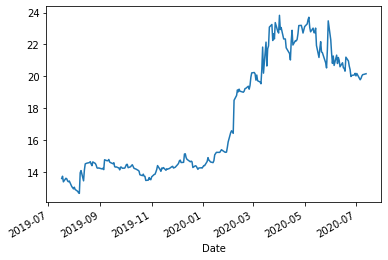

In [71]:
plt.close('all')
ratios["NLOK"].tail(250).plot()

In [ ]:
output = pytrade.analysis_1.run(ratios)
output.sort_values(by="short_term_metric",ascending=False,inplace=True)
output